# Prediction Algorithms Complete

## Preliminaries

In [1]:
import copy
import os
import sys
import networkx as nx
import numpy as np

from os.path import dirname
from networkx.drawing.nx_pydot import to_pydot

# Import morpheus
note_dir = os.getcwd()
root_dir = dirname(note_dir)
src_dir = os.path.join(root_dir, "src")

sys.path.append(src_dir)

import morpheus

from morpheus.tests import (default_dataset,
                            default_m_list_for_mercs,
                            random_m_list_for_mercs)

from morpheus.graph import (model_to_graph,
                            fix_layout)

from morpheus.algo import (mi_algorithm,
                           ma_algorithm,
                           mrai_algorithm,
                          it_algorithm)

In [2]:
from IPython.display import Image, display
from IPython.core.display import HTML 

### Methods

In [3]:
def to_dot(g, dname='tmp', fname='test', extension='.dot', return_fname=False, ortho=False, fi_labels=False):
    """
    Convert a graph to a dot file.
    """
    
    # Layout
    if fi_labels:
        for e in g.edges():
            g.edges()[e]['label'] = "{0:.2f}".format(g.edges()[e].get('fi', 0))
    
    dot = nx.drawing.nx_pydot.to_pydot(g)
    dot.set('rankdir', 'BT')
    
    if ortho:
        dot.set('splines', 'ortho')
    
    # To file
    full_fname = os.path.join(dname, fname+extension)
    
    with open(full_fname, "w") as f:
        print(dot.to_string(), file=f)
    
    if return_fname:
        return full_fname
    else:
        return

## Collect Basic Building Blocks

In [4]:
a = [1,2,3]
a[-1:]

[3]

In [5]:
data, _ = default_dataset()
data = data.values
m_list = default_m_list_for_mercs(data)

g_list = [model_to_graph(m, idx) for idx, m in enumerate(m_list)]
g_list = [fix_layout(g) for g in g_list]


        Learning model with desc ids:    [1, 2, 3, 4, 5, 6, 7]
                            targ ids:    [0]
        

        Learning model with desc ids:    [0, 1, 2, 3, 5, 6, 7]
                            targ ids:    [4]
        

        Learning model with desc ids:    [0, 1, 2, 3, 4, 6, 7]
                            targ ids:    [5]
        

        Learning model with desc ids:    [0, 1, 2, 3, 4, 5, 7]
                            targ ids:    [6]
        

        Learning model with desc ids:    [0, 2, 3, 4, 5, 6, 7]
                            targ ids:    [1]
        

        Learning model with desc ids:    [0, 1, 3, 4, 5, 6, 7]
                            targ ids:    [2]
        

        Learning model with desc ids:    [0, 1, 2, 3, 4, 5, 6]
                            targ ids:    [7]
        

        Learning model with desc ids:    [0, 1, 2, 4, 5, 6, 7]
                            targ ids:    [3]
        


## MI

Testing our most basic prediction algorithm.

In [6]:
# compute
q_code = np.array([0,0,0,0,0,-1,1,1])
g_res = mi_algorithm(g_list, q_code)

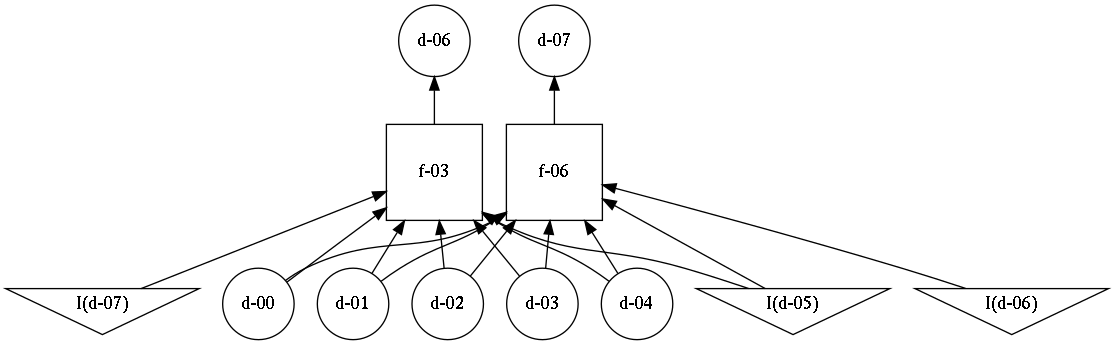

In [7]:
# show your work
fname = to_dot(g_res, fname='mi')
!dot -T png ./tmp/mi.dot > ./tmp/mi.png  # Bash command (This can be done nicer, but is tricky)

display(Image('tmp/mi.png', unconfined=True))

## MA

Slightly more advanced algorithm

In [8]:
# Preliminaries
m_list_random = random_m_list_for_mercs(data, random_state=16)
m_list_random += random_m_list_for_mercs(data, random_state=18)

g_list_random = [model_to_graph(m, idx) for idx, m in enumerate(m_list_random)]
g_list_random = [fix_layout(g) for g in g_list_random]

In [9]:
# Compute
q_code = np.array([-1,0,0,0,0,-1,1,0])
g_res = ma_algorithm(g_list_random, q_code, init_threshold = 0.9)


            We have selected 1 model(s) at threshold: 0.70
            



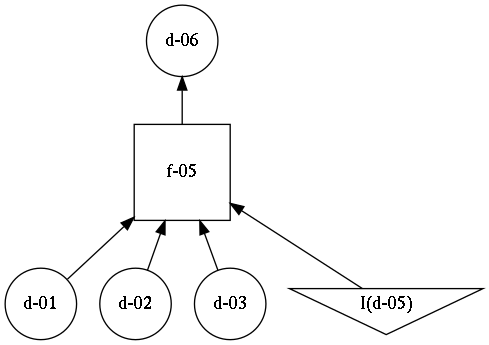

In [10]:
# show your work
fname = to_dot(g_res, fname='ma')
!dot -T png ./tmp/ma.dot > ./tmp/ma.png  # Bash command (This can be done nicer, but is tricky)

display(Image('tmp/ma.png', unconfined=True))

## MRAI

The most important single-layer algorithm

### Vanilla

In [11]:
# Create model
data, _ = default_dataset()
data = data.values

m_list_mrai = random_m_list_for_mercs(data, random_state=3)
m_list_mrai += random_m_list_for_mercs(data, random_state=4)

g_list_mrai = [model_to_graph(m, idx) for idx, m in enumerate(m_list_mrai)]
g_list_mrai = [fix_layout(g) for g in g_list_mrai]


                        We have selected    1 model(s) 
                        at threshold:       0.84
                        with model ids:     [['f-05']]
                        



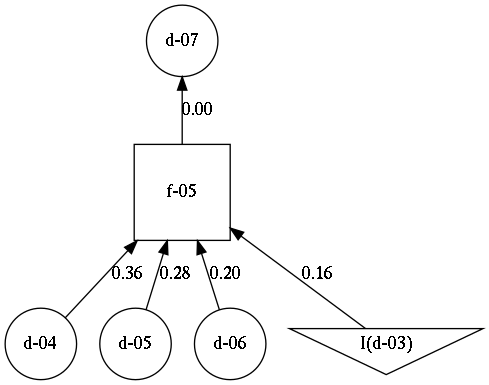

In [12]:
# Compute
q_code = np.array([-1,0,0,-1,0,0,0,1])
g_mrai = mrai_algorithm(g_list_mrai, q_code, init_threshold=0.9, stepsize=0.01)

# show your work
fname = to_dot(g_mrai, fname='mrai', fi_labels=True)
!dot -T png ./tmp/mrai.dot > ./tmp/mrai.png  # Bash command (This can be done nicer, but is tricky)

display(Image('tmp/mrai.png', unconfined=True))

### Bit more to the test

Really elaborate hack to manually change feature importances at model level. Nevermind this, just to prove a point.

In [13]:
class hack_fi(object):
    def __init__(self, model):
        
        a = m.feature_importances_
        a[1] += a[0] - 0.01
        a[0] = 0.01
        
        print(a)
        
        self.feature_importances_ = a
        
        for x in dir(m):
            if x.startswith('_'):
                pass
            elif x.startswith('feature_'):
                pass
            else:
                self.__setattr__(x, m.__getattribute__(x))
        
        return 


In [14]:
m = copy.deepcopy(g_list_mrai[5].nodes()['f-05']['mod'])
m = hack_fi(m)

g = model_to_graph(m, idx=99)
g = fix_layout(g)
g_list_mrai_two = g_list_mrai + [g]

[0.01       0.5093167  0.28488012 0.19580318]



                        We have selected    1 model(s) 
                        at threshold:       0.79
                        with model ids:     [['f-99']]
                        



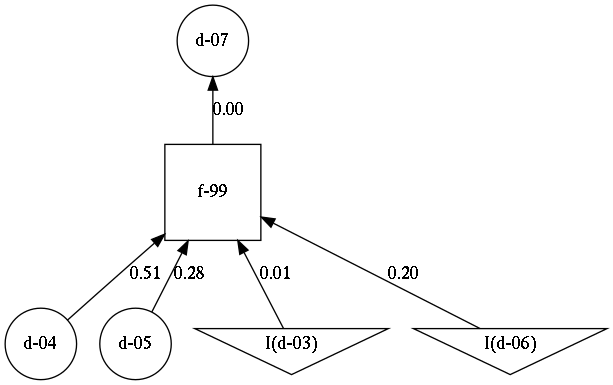

In [15]:
# Compute
q_code = np.array([-1,0,0,-1,0,0,1,1])
g_mrai = mrai_algorithm(g_list_mrai_two, q_code, init_threshold=0.9, stepsize=0.01, complete=False)

# show your work
fname = to_dot(g_mrai, fname='mrai', fi_labels=True)
!dot -T png ./tmp/mrai.dot > ./tmp/mrai.png  # Bash command (This can be done nicer, but is tricky)

display(Image('tmp/mrai.png', unconfined=True))

In [16]:
from functools import reduce
outputs = []
#reduce(set.union, outputs)
x = reduce(set.union, outputs, set())

In [17]:
x == set([])

True

In [18]:
set([])

set()

lgtm

# Multi-Layer Algorithms

## IT

In [19]:
# Create model
data, _ = default_dataset(n_features=10)
data = data.values

m_list_it = random_m_list_for_mercs(data, its=4, fraction=0.4,random_state=3)

g_list_it = [model_to_graph(m, idx) for idx, m in enumerate(m_list_it)]
g_list_it = [fix_layout(g) for g in g_list_it]

In [20]:
data.shape

(800, 11)


        Starting step:      0
        Available targets:  {0, 2, 4, 5, 6, 8, 10}
        Available desc   :  {1, 3, 9, 7}
        


                        We have selected    1 model(s) 
                        at threshold:       0.80
                        with model ids:     [['f-36']]
                        


        Starting step:      1
        Available targets:  {2, 4, 5, 6, 8, 10}
        Available desc   :  {0, 1, 3, 7, 9}
        


                        We have selected    2 model(s) 
                        at threshold:       0.80
                        with model ids:     [['f-09'], ['f-32']]
                        


        Starting step:      2
        Available targets:  {8, 10}
        Available desc   :  {0, 1, 2, 3, 5, 7, 9}
        


                        We have selected    2 model(s) 
                        at threshold:       0.90
                        with model ids:     [['f-19'], ['f-41']]
                        



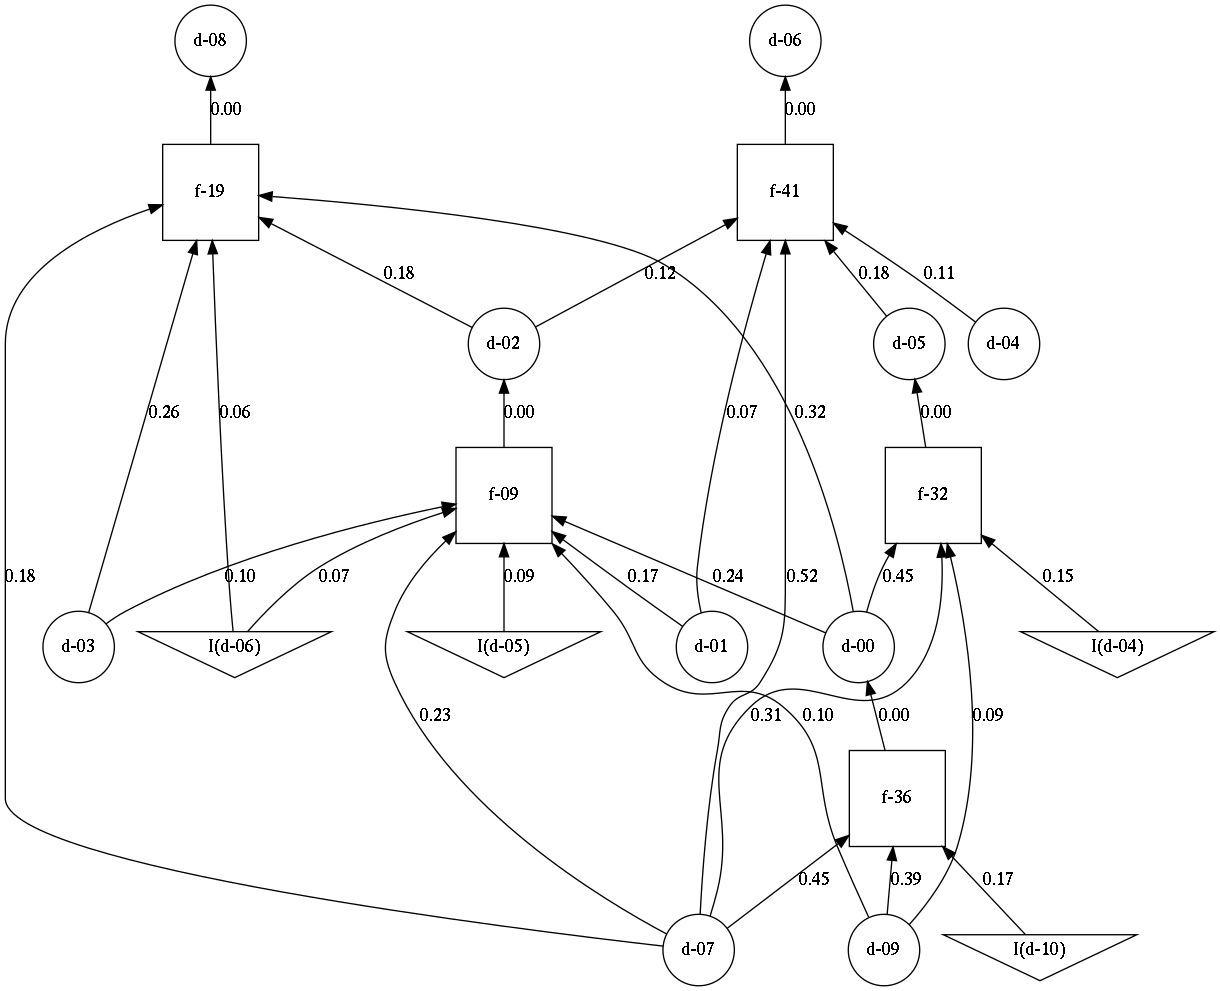

In [21]:
# Compute
q_code = np.array([-1,0,-1,0,-1, -1,-1,0,1,0, 1])
g_it = it_algorithm(g_list_it, q_code, max_steps=3)

# show your work
fname = to_dot(g_it, fname='it', fi_labels=True)
!dot -T png ./tmp/it.dot > ./tmp/it.png  # Bash command (This can be done nicer, but is tricky)

display(Image('tmp/it.png'))